In [95]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [114]:
def preprocess_features(df):
    #normalized_df=(df-df.mean())/df.std()
    #normalized_df=(df-df.min())/(df.max()-df.min())
    
    processed_features = pd.DataFrame()
    processed_features["Act_A"] = (df["Act_A"] / 150.0)
    processed_features["Act_B"] = (df["Act_B"] / 150.0)
    processed_features["Frac_A"] = (df["Frac_A"] / 100.0)
    processed_features["Gas_A"] = (df['Gas_A']/(df['Gas_A']+df['Dense_A']))
    processed_features["Gas_B"] = (df['Gas_B']/(df['Gas_B']+df['Dense_B']))
    processed_features["Dense_A"] = (df['Dense_A']/(df['Gas_A']+df['Dense_A']))
    processed_features["Dense_B"] = (df['Dense_B']/(df['Gas_B']+df['Dense_B']))
    processed_features["Lg_clust"] = (df['Lg_clust']/(df['Gas_A']+df['Dense_A']+df['Gas_B']+df['Dense_B']))                                 
                                     
    return processed_features

In [115]:
features = pd.read_pickle('phaseSeparationFeatures.pkl')
features = features.reindex(
    np.random.permutation(features.index))

targets = pd.DataFrame({'Phase_Sep': features['Phase_Sep']})

features = features.drop(columns=['Phase_Sep', 'Timestep', 'Gas_tot', 'Dense_tot'])

training_examples = preprocess_features(features.head(int(1080*.7)))
training_targets = targets.head(int(1080*.7))

validation_examples = preprocess_features(features.tail(int(1080*.3)))
validation_targets = targets.tail(int(1080*.3))

In [116]:
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,Act_A,Act_B,Frac_A,Gas_A,Gas_B,Dense_A,Dense_B,Lg_clust
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.302116,0.687125,0.503042,0.998426,0.507885,0.001574,0.492115,0.000201
std,0.237205,0.237113,0.253356,0.036362,0.313369,0.036362,0.313369,0.000363
min,0.000000,0.066667,0.100000,0.000000,0.092111,0.000022,0.000000,0.000000
25%,0.133333,0.533333,0.300000,0.999700,0.221187,0.000053,0.224844,0.000090
50%,0.266667,0.733333,0.500000,0.999890,0.439750,0.000110,0.560250,0.000211
75%,0.466667,0.866667,0.700000,0.999947,0.775156,0.000300,0.778812,0.000258
max,0.933333,1.000000,0.900000,0.999978,1.000000,1.000000,0.907889,0.009073


Validation examples summary:


,Act_A,Act_B,Frac_A,Gas_A,Gas_B,Dense_A,Dense_B,Lg_clust
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,0.332099,0.693004,0.492901,0.999454,0.479419,0.000546,0.520581,0.000239
std,0.253653,0.255047,0.269811,0.004885,0.312082,0.004885,0.312082,0.000847
min,0.000000,0.066667,0.100000,0.912408,0.099000,0.000022,0.000000,0.000000
25%,0.133333,0.533333,0.200000,0.999723,0.195738,0.000048,0.311458,0.000131
50%,0.266667,0.733333,0.500000,0.999906,0.419444,0.000094,0.580556,0.000217
75%,0.533333,0.933333,0.700000,0.999952,0.688542,0.000277,0.804262,0.000259
max,0.933333,1.000000,0.900000,0.999978,1.000000,0.087592,0.901000,0.015297


Training targets summary:


,Phase_Sep
count,756.000000
mean,0.718254
std,0.450148
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Validation targets summary:


,Phase_Sep
count,324.000000
mean,0.762346
std,0.426305
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [117]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["Phase_Sep"] = training_targets["Phase_Sep"]

correlation_dataframe.corr()

,Act_A,Act_B,Frac_A,Gas_A,Gas_B,Dense_A,Dense_B,Lg_clust,Phase_Sep
Act_A,1.000000,0.489154,-0.014580,-0.082034,-0.813694,0.082034,0.813694,0.209412,0.542700
Act_B,0.489154,1.000000,0.000138,-0.030808,-0.602660,0.030808,0.602660,0.144674,0.578569
Frac_A,-0.014580,0.000138,1.000000,-0.029575,0.277926,0.029575,-0.277926,-0.148448,-0.349011
Gas_A,-0.082034,-0.030808,-0.029575,1.000000,-0.063911,-1.000000,0.063911,0.020101,-0.016084
Gas_B,-0.813694,-0.602660,0.277926,-0.063911,1.000000,0.063911,-1.000000,-0.305998,-0.867649
Dense_A,0.082034,0.030808,0.029575,-1.000000,0.063911,1.000000,-0.063911,-0.020101,0.016084
Dense_B,0.813694,0.602660,-0.277926,0.063911,-1.000000,-0.063911,1.000000,0.305998,0.867649
Lg_clust,0.209412,0.144674,-0.148448,0.020101,-0.305998,-0.020101,0.305998,1.000000,0.289661
Phase_Sep,0.542700,0.578569,-0.349011,-0.016084,-0.867649,0.016084,0.867649,0.289661,1.000000


In [118]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
    A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [131]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
  
    Args:
      learning_rate: A `float`, the learning rate.
      steps: A non-zero `int`, the total number of training steps. A training step
        consists of a forward and backward pass using a single batch.
      feature_columns: A `set` specifying the input feature columns to use.
      training_examples: A `DataFrame` containing one or more columns from
       `california_housing_dataframe` to use as input features for training.
      training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
      validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
     validation_targets: A `DataFrame` containing exactly one column from
       `california_housing_dataframe` to use as target for validation.
      
    Returns:
    A `LinearRegressor` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets["Phase_Sep"], 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets["Phase_Sep"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                      validation_targets["Phase_Sep"], 
                                                      num_epochs=1, 
                                                      shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.20
  period 01 : 0.18
  period 02 : 0.18
  period 03 : 0.17
  period 04 : 0.18
  period 05 : 0.18
  period 06 : 0.18
  period 07 : 0.17
  period 08 : 0.17
  period 09 : 0.17
Model training finished.


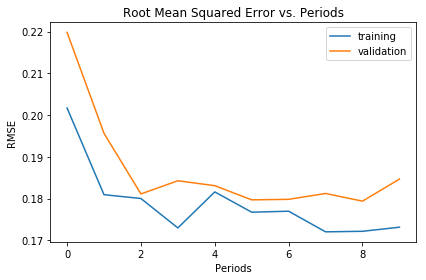

In [133]:
_ = train_model(
    learning_rate=0.5,
    steps=2000,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [122]:
training_examples

,Act_A,Act_B,Frac_A,Gas_A,Gas_B,Dense_A,Dense_B,Lg_clust
654,0.266667,0.866667,0.7,0.999856,0.569429,0.000144,0.430571,0.000133
434,0.133333,0.933333,0.3,0.999940,0.398222,0.000060,0.601778,0.000197
482,0.133333,0.400000,0.6,0.999400,1.000000,0.000600,0.000000,0.000000
221,0.066667,0.933333,0.6,0.999853,0.645222,0.000147,0.354778,0.000110
622,0.266667,0.666667,0.2,0.999919,0.362667,0.000081,0.637333,0.000279
209,0.066667,0.866667,0.3,0.999907,0.520444,0.000093,0.479556,0.000184
822,0.400000,0.733333,0.4,0.999928,0.281500,0.000072,0.718500,0.000255
773,0.333333,1.000000,0.9,0.999905,0.414296,0.000095,0.585704,0.000145
649,0.266667,0.866667,0.2,0.999947,0.379667,0.000053,0.620333,0.000224
523,0.200000,0.733333,0.2,0.999922,0.440333,0.000078,0.559667,0.000249
